#Notes and Refrences

This document explores a general process for loading, filtering, dimention reduction and clustering using PCA and K-means.

Evalutation is done with distence calculations and silhoutte analysis

See: 

https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a


Drachen, A., Sifa, R., Bauckhage, C., & Thurau, C. (2012). Guns, swords and data: Clustering of player behavior in computer games in the wild. 2012 IEEE Conference on Computational Intelligence and Games (CIG), 163–170. https://doi.org/10.1109/CIG.2012.6374152


## Read in everything

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
from math import ceil
import numpy as np
pd.options.display.max_columns = 1000
from google.colab import files
import urllib.request
from zipfile import ZipFile
from io import BytesIO

Open proc_zip from url as a dataframe

In [24]:
proc_zip_url = 'https://github.com/fielddaylab/opengamedata/blob/master/jupyter/lakeland_data/LAKELAND_20191201_to_20191231_b2cf46d_proc.zip?raw=true'
resp = urllib.request.urlopen(proc_zip_url)
zipfile = ZipFile(BytesIO(resp.read()))
with zipfile.open(zipfile.namelist()[0]) as f:
    df = pd.read_csv(f)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1599) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
print(df.shape)
df.head()

(17116, 1600)


,lvl0_EventCount,lvl1_EventCount,lvl2_EventCount,lvl3_EventCount,lvl4_EventCount,lvl5_EventCount,lvl6_EventCount,lvl7_EventCount,lvl8_EventCount,lvl9_EventCount,lvl0_ActiveEventCount,lvl1_ActiveEventCount,lvl2_ActiveEventCount,lvl3_ActiveEventCount,lvl4_ActiveEventCount,lvl5_ActiveEventCount,lvl6_ActiveEventCount,lvl7_ActiveEventCount,lvl8_ActiveEventCount,lvl9_ActiveEventCount,lvl0_durationInSecs,lvl1_durationInSecs,lvl2_durationInSecs,lvl3_durationInSecs,lvl4_durationInSecs,lvl5_durationInSecs,lvl6_durationInSecs,lvl7_durationInSecs,lvl8_durationInSecs,lvl9_durationInSecs,lvl0_count_gamestate_logs,lvl1_count_gamestate_logs,lvl2_count_gamestate_logs,lvl3_count_gamestate_logs,lvl4_count_gamestate_logs,lvl5_count_gamestate_logs,lvl6_count_gamestate_logs,lvl7_count_gamestate_logs,lvl8_count_gamestate_logs,lvl9_count_gamestate_logs,lvl0_count_achievements,lvl1_count_achievements,lvl2_count_achievements,lvl3_count_achievements,lvl4_count_achievements,lvl5_count_achievements,lvl6_count_achievements,lvl7_count_achievements,lvl8_count_achievements,lvl9_count_achievements,lvl0_count_buy_home,lvl1_count_buy_home,lvl2_count_buy_home,lvl3_count_buy_home,lvl4_count_buy_home,lvl5_count_buy_home,lvl6_count_buy_home,lvl7_count_buy_home,lvl8_count_buy_home,lvl9_count_buy_home,lvl0_count_buy_food,lvl1_count_buy_food,lvl2_count_buy_food,lvl3_count_buy_food,lvl4_count_buy_food,lvl5_count_buy_food,lvl6_count_buy_food,lvl7_count_buy_food,lvl8_count_buy_food,lvl9_count_buy_food,lvl0_count_buy_farm,lvl1_count_buy_farm,lvl2_count_buy_farm,lvl3_count_buy_farm,lvl4_count_buy_farm,lvl5_count_buy_farm,lvl6_count_buy_farm,lvl7_count_buy_farm,lvl8_count_buy_farm,lvl9_count_buy_farm,lvl0_count_buy_fertilizer,lvl1_count_buy_fertilizer,lvl2_count_buy_fertilizer,lvl3_count_buy_fertilizer,lvl4_count_buy_fertilizer,lvl5_count_buy_fertilizer,lvl6_count_buy_fertilizer,lvl7_count_buy_fertilizer,lvl8_count_buy_fertilizer,lvl9_count_buy_fertilizer,lvl0_count_buy_livestock,lvl1_count_buy_livestock,lvl2_count_buy_livestock,lvl3_count_buy_livestock,lvl4_count_buy_livestock,lvl5_count_buy_livestock,lvl6_count_buy_livestock,lvl7_count_buy_livestock,lvl8_count_buy_livestock,lvl9_count_buy_livestock,lvl0_count_buy_skimmer,lvl1_count_buy_skimmer,lvl2_count_buy_skimmer,lvl3_count_buy_skimmer,lvl4_count_buy_skimmer,lvl5_count_buy_skimmer,lvl6_count_buy_skimmer,lvl7_count_buy_skimmer,lvl8_count_buy_skimmer,lvl9_count_buy_skimmer,lvl0_count_buy_sign,lvl1_count_buy_sign,lvl2_count_buy_sign,lvl3_count_buy_sign,lvl4_count_buy_sign,lvl5_count_buy_sign,lvl6_count_buy_sign,lvl7_count_buy_sign,lvl8_count_buy_sign,lvl9_count_buy_sign,lvl0_count_buy_road,lvl1_count_buy_road,lvl2_count_buy_road,lvl3_count_buy_road,lvl4_count_buy_road,lvl5_count_buy_road,lvl6_count_buy_road,lvl7_count_buy_road,lvl8_count_buy_road,lvl9_count_buy_road,lvl0_money_spent,lvl1_money_spent,lvl2_money_spent,lvl3_money_spent,lvl4_money_spent,lvl5_money_spent,lvl6_money_spent,lvl7_money_spent,lvl8_money_spent,lvl9_money_spent,lvl0_money_spent_home,lvl1_money_spent_home,lvl2_money_spent_home,lvl3_money_spent_home,lvl4_money_spent_home,lvl5_money_spent_home,lvl6_money_spent_home,lvl7_money_spent_home,lvl8_money_spent_home,lvl9_money_spent_home,lvl0_money_spent_food,lvl1_money_spent_food,lvl2_money_spent_food,lvl3_money_spent_food,lvl4_money_spent_food,lvl5_money_spent_food,lvl6_money_spent_food,lvl7_money_spent_food,lvl8_money_spent_food,lvl9_money_spent_food,lvl0_money_spent_farm,lvl1_money_spent_farm,lvl2_money_spent_farm,lvl3_money_spent_farm,lvl4_money_spent_farm,lvl5_money_spent_farm,lvl6_money_spent_farm,lvl7_money_spent_farm,lvl8_money_spent_farm,lvl9_money_spent_farm,lvl0_money_spent_fertilizer,lvl1_money_spent_fertilizer,lvl2_money_spent_fertilizer,lvl3_money_spent_fertilizer,lvl4_money_spent_fertilizer,lvl5_money_spent_fertilizer,lvl6_money_spent_fertilizer,lvl7_money_spent_fertilizer,lvl8_money_spent_fertilizer,lvl9_money_spent_fertilizer,lvl0_money_spent_livestock,lvl1_money_spent_livestock,lvl2_money_spen

## Filtering
- Filtered out the sessions that used SPYPARTY (debug=1)
- Filtered any sessions that were not between 600 seconds (10 min) and 3600 seconds (60 min)
- Filtered out continues
- Filtered out any sessions that did not have at least 5 active events in lvl0 and lvl5

In [45]:
df = df[df['debug'] < 1]
df = df[df['continue'] > 0]
df = df[(600 < df['sessDuration']) & (df['sessDuration'] < 3600)]
df = df[df['lvl0_ActiveEventCount'] > 5]
df = df[df['lvl5_ActiveEventCount'] > 5]
df

lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  lvl3_EventCount  \
95                 307            502.0              NaN              NaN   
113                 96              NaN              NaN              NaN   
153                154              NaN              NaN              NaN   
168                415            403.0            465.0            667.0   
187                450            199.0             16.0              NaN   
...                ...              ...              ...              ...   
16912              413            381.0            281.0            207.0   
16941              347            336.0            399.0            452.0   
16971              396            606.0            285.0            298.0   
17050              450            334.0            299.0            224.0   
17087              383            412.0            437.0              NaN   

       lvl4_EventCount  lvl5_EventCount  lvl6_EventCount  lvl7_EventCount  \
95                 NaN             22.0              NaN              NaN   
113                7.0            105.0             84.0            103.0   
153               39.0            124.0              NaN              NaN   
168              657.0            316.0              NaN              NaN   
187              386.0            837.0           1192.0           1108.0   
...                ...              ...              ...              ...   
16912            858.0            201.0            204.0             69.0   
16941            565.0            603.0            477.0            138.0   
16971            306.0            339.0              NaN              NaN   
17050            223.0            113.0            188.0            214.0   
17087              NaN            397.0            193.0              NaN   

       lvl8_EventCount  lvl9_EventCount  lvl0_ActiveEventCount  \
95                 NaN              NaN                   41.0   
113               91.0             79.0                   32.0   
153                NaN              NaN                   81.0   
168                NaN              NaN                   84.0   
187              744.0              NaN                   59.0   
...                ...              ...                    ...   
16912              NaN              NaN                   53.0   
16941             21.0             21.0                   74.0   
16971              NaN              NaN                   79.0   
17050            382.0            201.0                   99.0   
17087              NaN              NaN                  160.0   

       lvl1_ActiveEventCount  lvl2_ActiveEventCount  lvl3_ActiveEventCount  \
95                      19.0                    NaN                    NaN   
113                      NaN                    NaN                    NaN   
153                      NaN                    NaN                    NaN   
168                     79.0                   77.0                   79.0   
187                     31.0                    3.0                    NaN   
...                      ...                    ...                    ...   
16912                   49.0                   53.0                   19.0   
16941                   54.0                   54.0                  135.0   
16971                  102.0                  138.0                   98.0   
17050                   97.0                  104.0                   84.0   
17087                  148.0                  129.0                    NaN   

       lvl4_ActiveEventCount  lvl5_ActiveEventCount  lvl6_ActiveEventCount  \
95                       NaN                    8.0                    NaN   
113                      3.0                   26.0                   39.0   
153                     25.0                   59.0                    NaN   
168                    103.0                   72.0                    NaN   
187                     23.0         

## Choose and Explore Features



In [0]:
hover_f_avg = lambda i, item: f'lvl{i}_avg_num_tiles_hovered_before_placing_{item}'
hover_f_tot = lambda i, item: f'lvl{i}_tot_num_tiles_hovered_before_placing_{item}'
for i in range(10):
  for item in ['home','food','farm','fertilizer','livestock','skimmer','sign','road']:
    df[hover_f_tot(i,item)] = df[hover_f_avg(i,item)].fillna(0) * df[f'lvl{i}_count_buy_{item}'].fillna(0)
  df[hover_f_tot(i,"buys")] = df.loc[:,hover_f_tot(i,"home"):hover_f_tot(i,"road")].sum(axis=1)
  df[f'lvl{i}_count_buys'] = df.loc[:,f'lvl{i}_count_buy_home':f'lvl{i}_count_buy_road'].fillna(0).sum(axis=1)

In [47]:
all_feats = [(i,c) for i,c in enumerate(df.columns)]
lvl0_feats = [f for f in all_feats if f[1].startswith("lvl0")]
lvl0_feats

[(0, 'lvl0_EventCount'),
 (10, 'lvl0_ActiveEventCount'),
 (20, 'lvl0_durationInSecs'),
 (30, 'lvl0_count_gamestate_logs'),
 (40, 'lvl0_count_achievements'),
 (50, 'lvl0_count_buy_home'),
 (60, 'lvl0_count_buy_food'),
 (70, 'lvl0_count_buy_farm'),
 (80, 'lvl0_count_buy_fertilizer'),
 (90, 'lvl0_count_buy_livestock'),
 (100, 'lvl0_count_buy_skimmer'),
 (110, 'lvl0_count_buy_sign'),
 (120, 'lvl0_count_buy_road'),
 (130, 'lvl0_money_spent'),
 (140, 'lvl0_money_spent_home'),
 (150, 'lvl0_money_spent_food'),
 (160, 'lvl0_money_spent_farm'),
 (170, 'lvl0_money_spent_fertilizer'),
 (180, 'lvl0_money_spent_livestock'),
 (190, 'lvl0_money_spent_skimmer'),
 (200, 'lvl0_money_spent_sign'),
 (210, 'lvl0_money_spent_road'),
 (220, 'lvl0_min_num_home_in_play'),
 (230, 'lvl0_max_num_home_in_play'),
 (240, 'lvl0_min_num_food_in_play'),
 (250, 'lvl0_max_num_food_in_play'),
 (260, 'lvl0_min_num_farm_in_play'),
 (270, 'lvl0_max_num_farm_in_play'),
 (280, 'lvl0_min_num_fertilizer_in_play'),
 (290, 'lvl0_ma

In [0]:
feature_names = [
  'count_deaths',
  'count_blooms',
  'count_achievements',
  'max_num_farm_in_play',
  'max_num_livestock_in_play',
  'max_num_home_in_play'                  
]
levels = range(6)
df2 = df.loc[:,[f'lvl{i}_{fn}' for fn in feature_names for i in levels]].fillna(0)
for fn in feature_names:
  df2[f'sum_{fn}_to_lvl_{levels[-1]}'] = df2[[f'lvl{i}_{fn}' for i in levels]].sum(axis=1)

In [49]:
df2

,lvl0_count_deaths,lvl1_count_deaths,lvl2_count_deaths,lvl3_count_deaths,lvl4_count_deaths,lvl5_count_deaths,lvl0_count_blooms,lvl1_count_blooms,lvl2_count_blooms,lvl3_count_blooms,lvl4_count_blooms,lvl5_count_blooms,lvl0_count_achievements,lvl1_count_achievements,lvl2_count_achievements,lvl3_count_achievements,lvl4_count_achievements,lvl5_count_achievements,lvl0_max_num_farm_in_play,lvl1_max_num_farm_in_play,lvl2_max_num_farm_in_play,lvl3_max_num_farm_in_play,lvl4_max_num_farm_in_play,lvl5_max_num_farm_in_play,lvl0_max_num_livestock_in_play,lvl1_max_num_livestock_in_play,lvl2_max_num_livestock_in_play,lvl3_max_num_livestock_in_play,lvl4_max_num_livestock_in_play,lvl5_max_num_livestock_in_play,lvl0_max_num_home_in_play,lvl1_max_num_home_in_play,lvl2_max_num_home_in_play,lvl3_max_num_home_in_play,lvl4_max_num_home_in_play,lvl5_max_num_home_in_play,sum_count_deaths_to_lvl_5,sum_count_blooms_to_lvl_5,sum_count_achievements_to_lvl_5,sum_max_num_farm_in_play_to_lvl_5,sum_max_num_livestock_in_play_to_lvl_5,sum_max_num_home_in_play_to_lvl_5
95,2.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,7.0,12.0,6.0,3.0
113,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,5.0,8.0,3.0,6.0
153,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,6.0,5.0,2.0,3.0
168,6.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,1.0,0.0,4.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,8.0,8.0,8.0,10.0,10.0,13.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,3.0,1.0,8.0,9.0,9.0,57.0,7.0,12.0
187,2.0,0.0,0.0,0.0,1.0,0.0,8.0,1.0,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,2.0,72.0,73.0,73.0,0.0,73.0,83.0,4.0,4.0,4.0,0.0,4.0,4.0,6.0,6.0,6.0,0.0,6.0,5.0,3.0,10.0,13.0,374.0,20.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16912,7.0,10.0,0.0,2.0,0.0,0.0,22.0,2.0,0.0,4.0,6.0,1.0,13.0,0.0,0.0,1.0,1.0,0.0,10.0,0.0,10.0,10.0,10.0,10.0,1.0,0.0,1.0,1.0,1.0,1.0,10.0,0.0,4.0,2.0,2.0,2.0,19.0,35.0,15.0,50.0,5.0,20.0
16941,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,11.0,0.0,0.0,0.0,1.0,1.0,29.0,29.0,30.0,40.0,53.0,63.0,2.0,2.0,2.0,2.0,2.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,6.0,13.0,244.0,13.0,30.0
16971,0.0,4.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,14.0,14.0,14.0,14.0,17.0,26.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,4.0,4.0,5.0,10.0,99.0,12.0,16.0
17050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,15.0,4.0,4.0


In [50]:
df3 = df2.loc[:, 'sum_count_deaths_to_lvl_5':'sum_max_num_home_in_play_to_lvl_5'].copy()
#df3 = df3.drop('sum_count_buys_to_lvl_5',axis=1)
#df3 = df3.rename(lambda s: s[4:-9],axis=1)
df3 = df3.fillna(0)
df3

,sum_count_deaths_to_lvl_5,sum_count_blooms_to_lvl_5,sum_count_achievements_to_lvl_5,sum_max_num_farm_in_play_to_lvl_5,sum_max_num_livestock_in_play_to_lvl_5,sum_max_num_home_in_play_to_lvl_5
95,3.0,3.0,7.0,12.0,6.0,3.0
113,2.0,0.0,5.0,8.0,3.0,6.0
153,4.0,1.0,6.0,5.0,2.0,3.0
168,8.0,9.0,9.0,57.0,7.0,12.0
187,3.0,10.0,13.0,374.0,20.0,29.0
...,...,...,...,...,...,...
16912,19.0,35.0,15.0,50.0,5.0,20.0
16941,1.0,6.0,13.0,244.0,13.0,30.0
16971,4.0,5.0,10.0,99.0,12.0,16.0
17050,0.0,0.0,4.0,15.0,4.0,4.0


In [51]:
df3.describe()

,sum_count_deaths_to_lvl_5,sum_count_blooms_to_lvl_5,sum_count_achievements_to_lvl_5,sum_max_num_farm_in_play_to_lvl_5,sum_max_num_livestock_in_play_to_lvl_5,sum_max_num_home_in_play_to_lvl_5
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,2.479839,3.233871,8.229839,76.907258,16.790323,18.020161
std,5.295288,11.841811,2.682904,121.144022,39.330588,22.013880
min,0.000000,0.000000,3.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,6.000000,25.000000,6.000000,7.000000
50%,1.000000,0.000000,8.000000,47.000000,10.000000,12.000000
75%,3.000000,3.000000,10.000000,80.250000,16.000000,22.000000
max,46.000000,164.000000,16.000000,1479.000000,475.000000,261.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdf6834b38>,
      dtype=object)

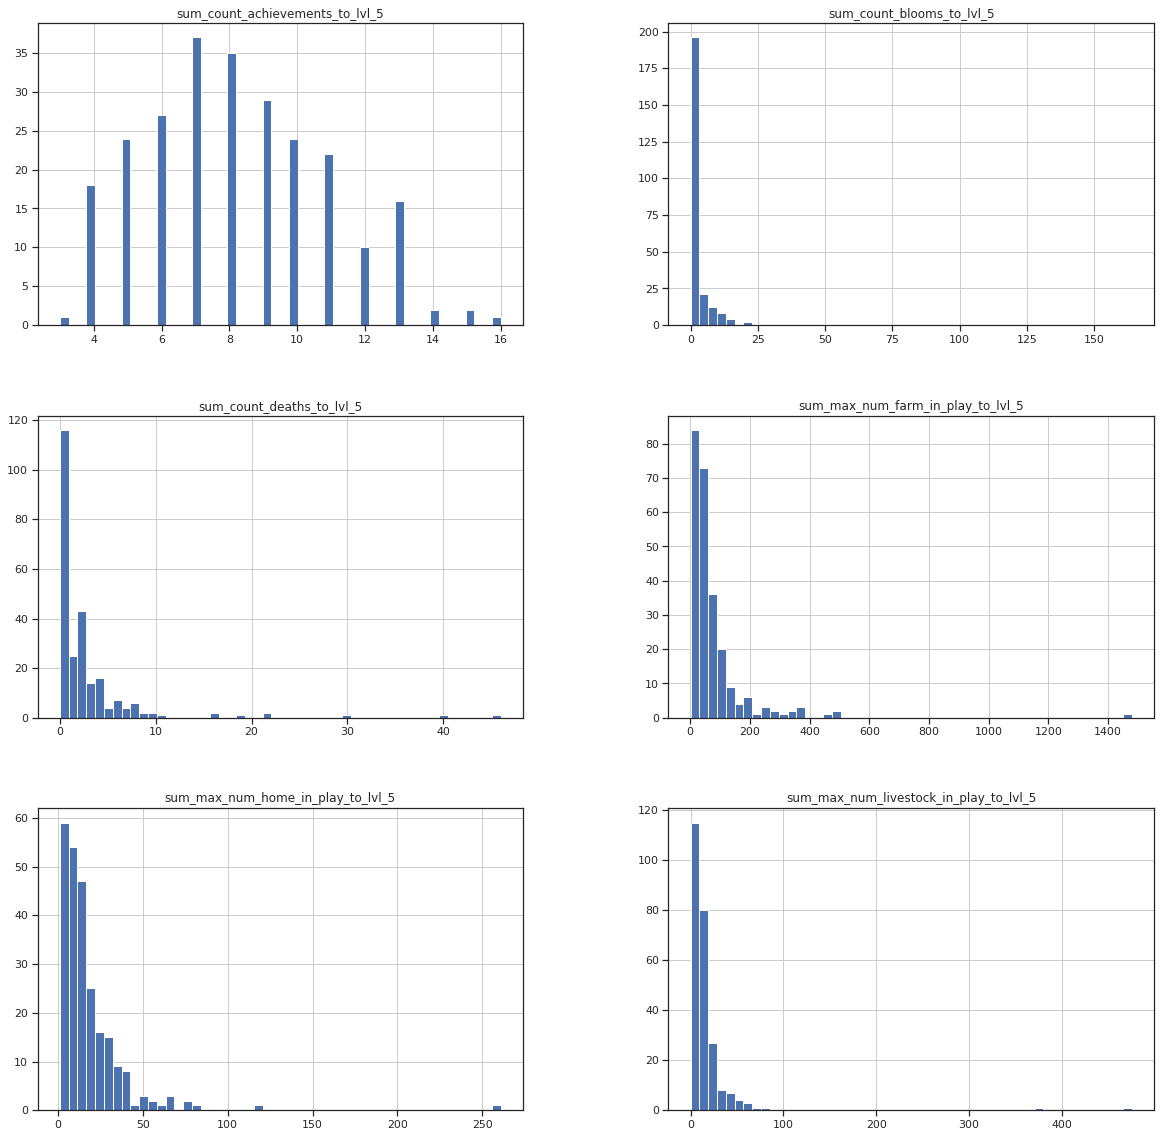

In [52]:
df3.hist(figsize=(20,20),bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdf6542a20>,
      dtype=object)

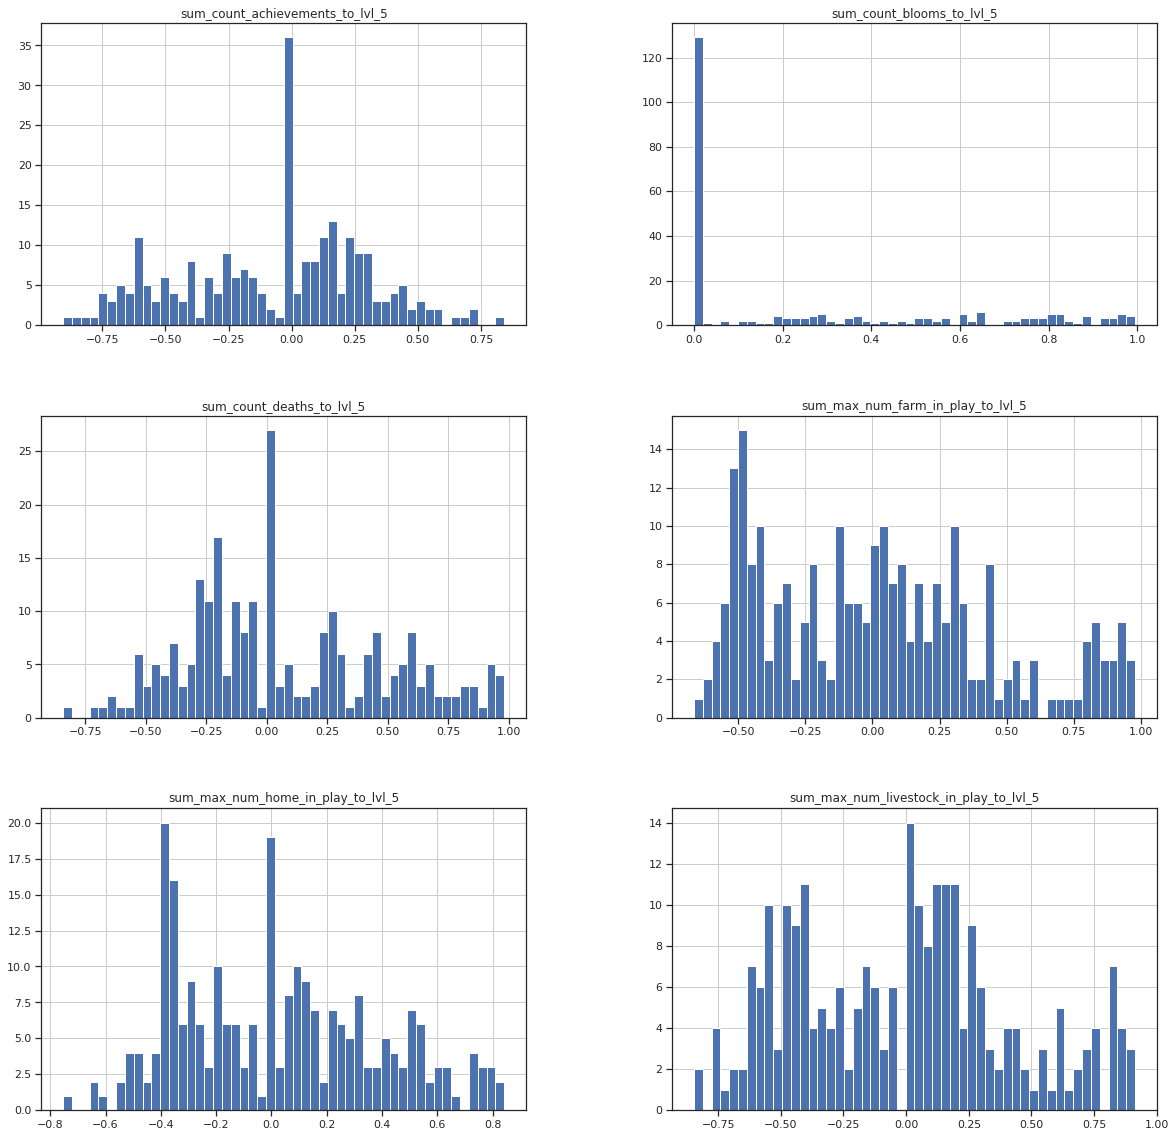

In [53]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

scale_normalize = make_pipeline(RobustScaler(), Normalizer())
X = scale_normalize.fit_transform(df3.to_numpy())
pd.DataFrame(X, columns = df3.columns).hist(figsize=(20,20),bins=50)

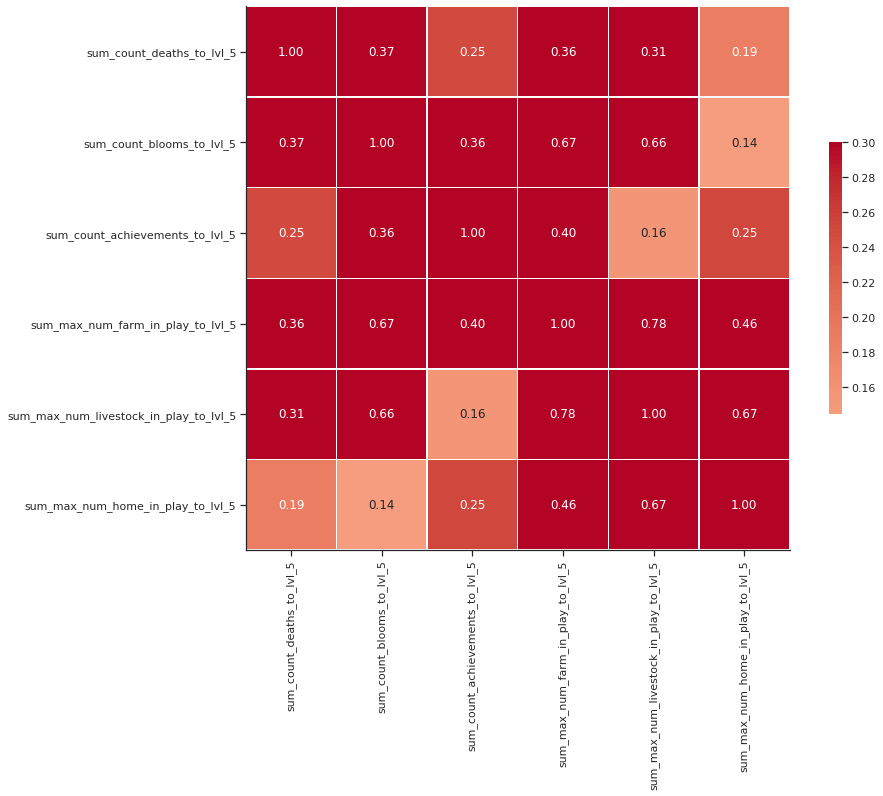

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
corr = df3.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

## Explore Eigenvalues  

Text(0, 0.5, 'Eigenvalue')

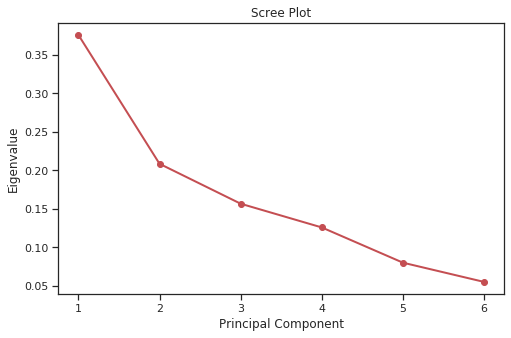

In [55]:
import numpy as np
U,S,V = np.linalg.svd(X)
eigvals = S**2 / np.sum(S**2)
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(X.shape[1]) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

## Explore PCA and K-Means Error

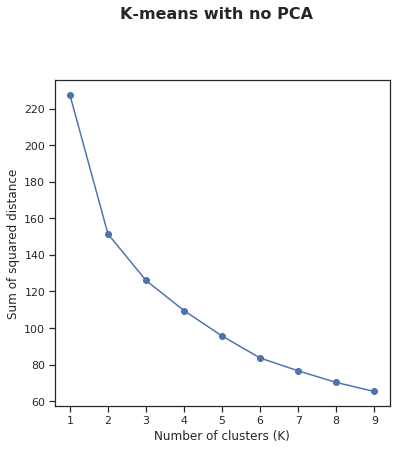

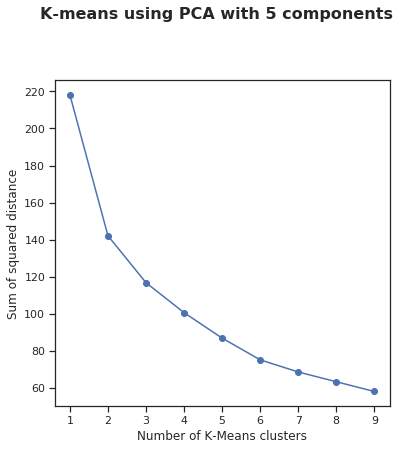

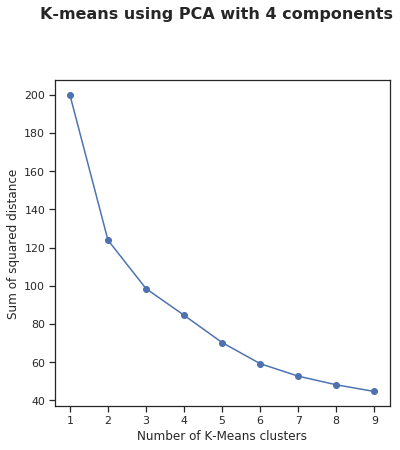

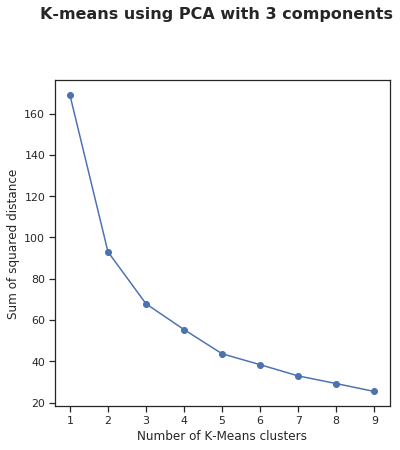

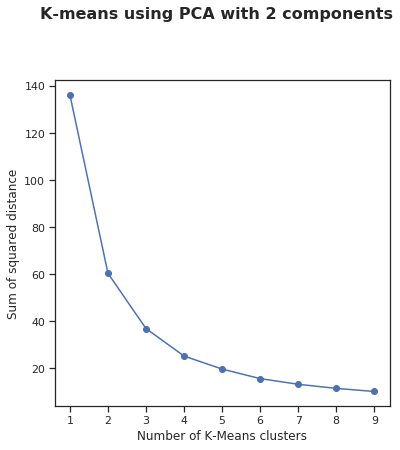

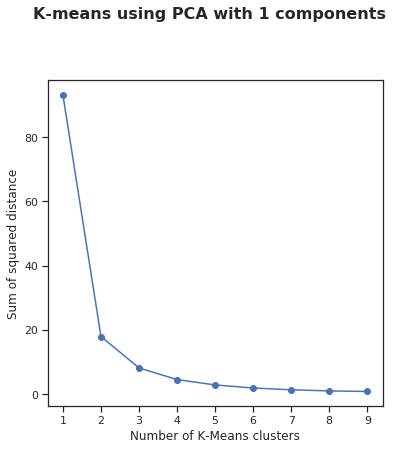

In [56]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.suptitle(f'K-means with no PCA',
                 fontsize=16, fontweight='semibold', y=1.05);
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of squared distance');


for i, components in enumerate([5, 4, 3, 2, 1]):
    # Project using PCA
    projected = PCA(components).fit_transform(X)
    sse = []
    list_k = list(range(1, 10))

    for k in list_k:
        km = KMeans(n_clusters = k)
        km.fit(projected)
        sse.append(km.inertia_)
    
    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.suptitle(f'K-means using PCA with {components} components',
                 fontsize=16, fontweight='semibold', y=1.05);
    plt.xlabel('Number of K-Means clusters')
    plt.ylabel('Sum of squared distance')


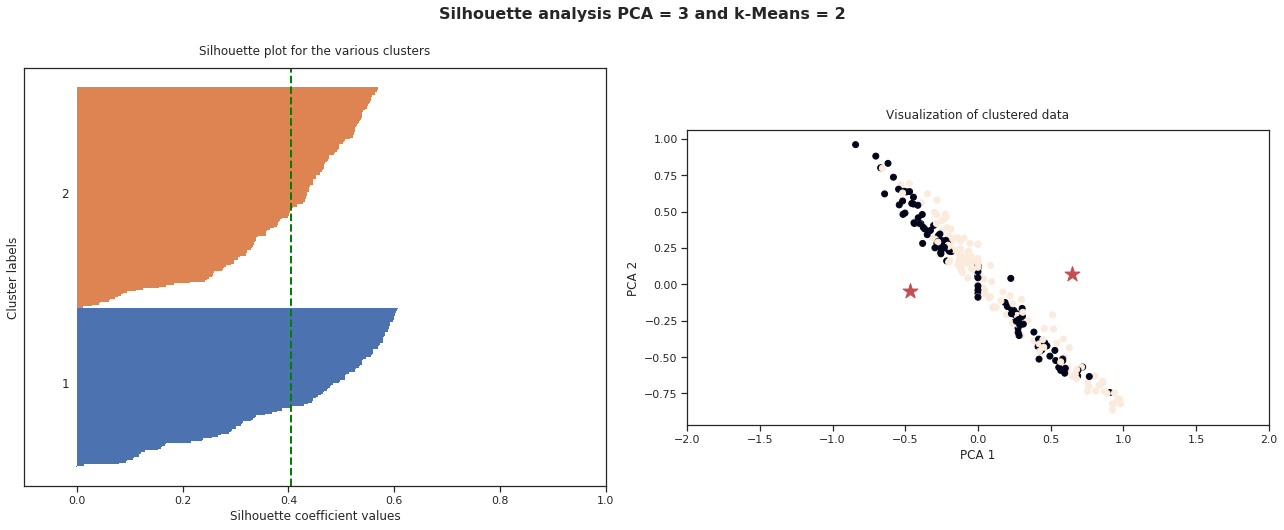

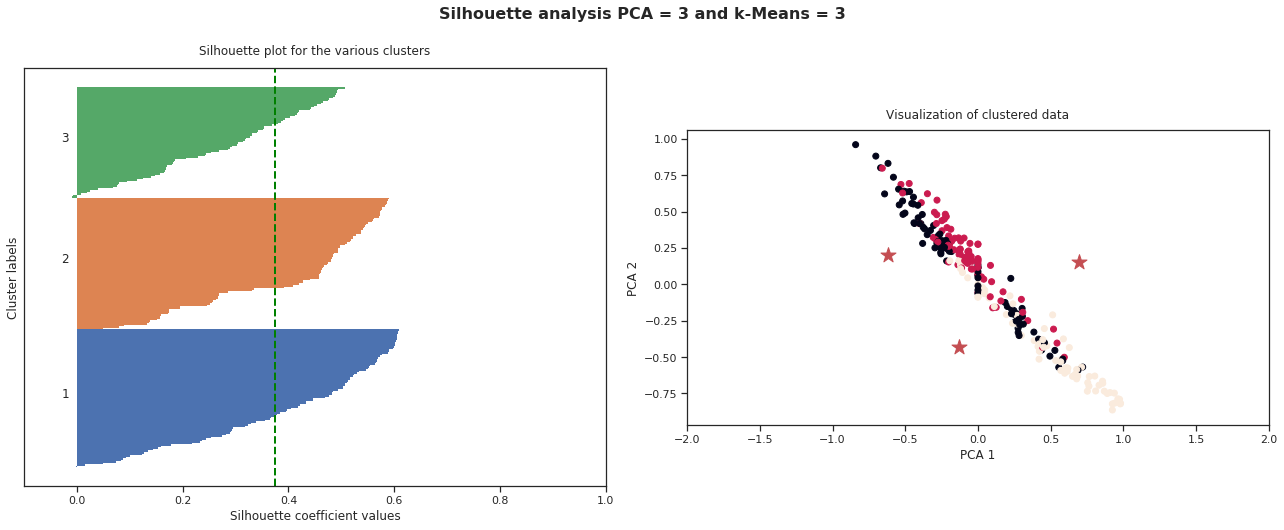

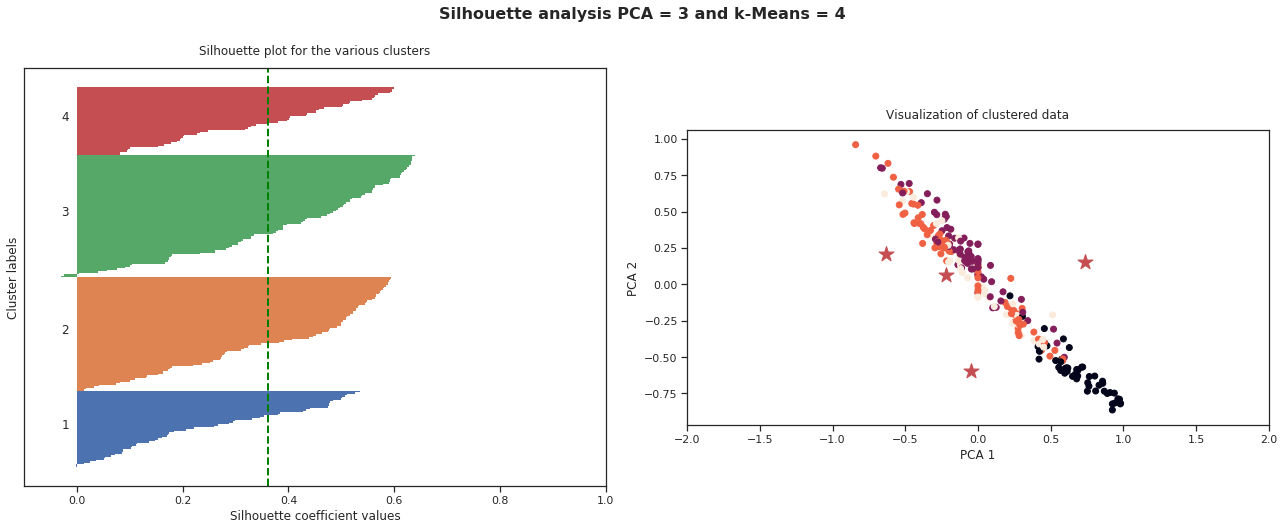

In [57]:
from sklearn.metrics import silhouette_samples

components = 3;
#projected = X
projected = PCA(components).fit_transform(X)


for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(projected)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(projected, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X[:, 0], projected[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('PCA 1')
    ax2.set_ylabel('PCA 2')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis PCA = {components} and k-Means = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

###Plot the PCA and K-Means

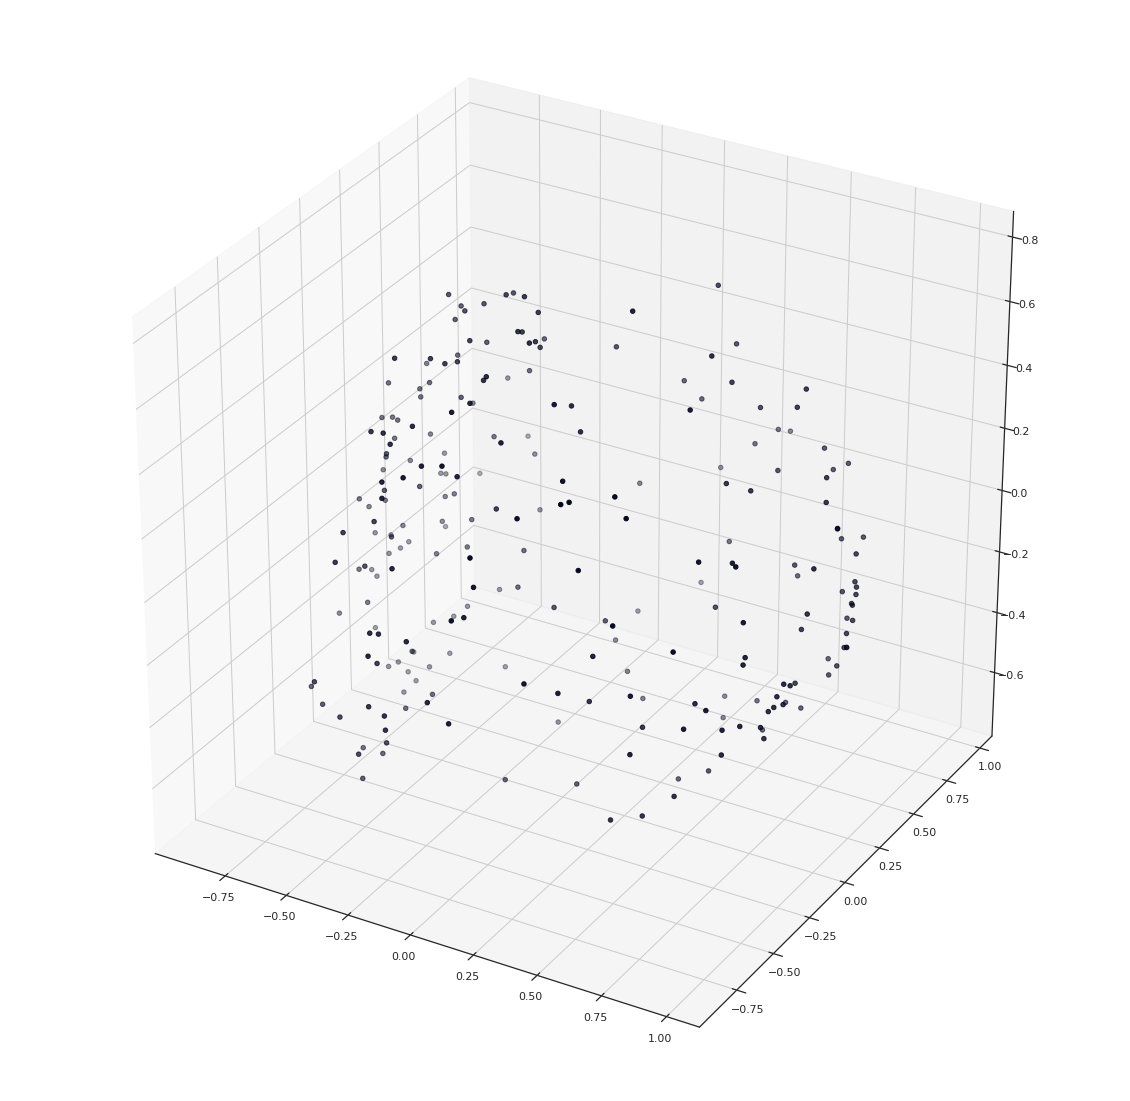

In [58]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
pca = PCA(n_components=3)
projected = pca.fit_transform(X)
kmeans = KMeans(1).fit(projected)
intent_labels=kmeans.labels_
ax.scatter3D(projected[:,0], projected[:,1], projected[:,2], c=kmeans.labels_);

Begin using Factor Analysis

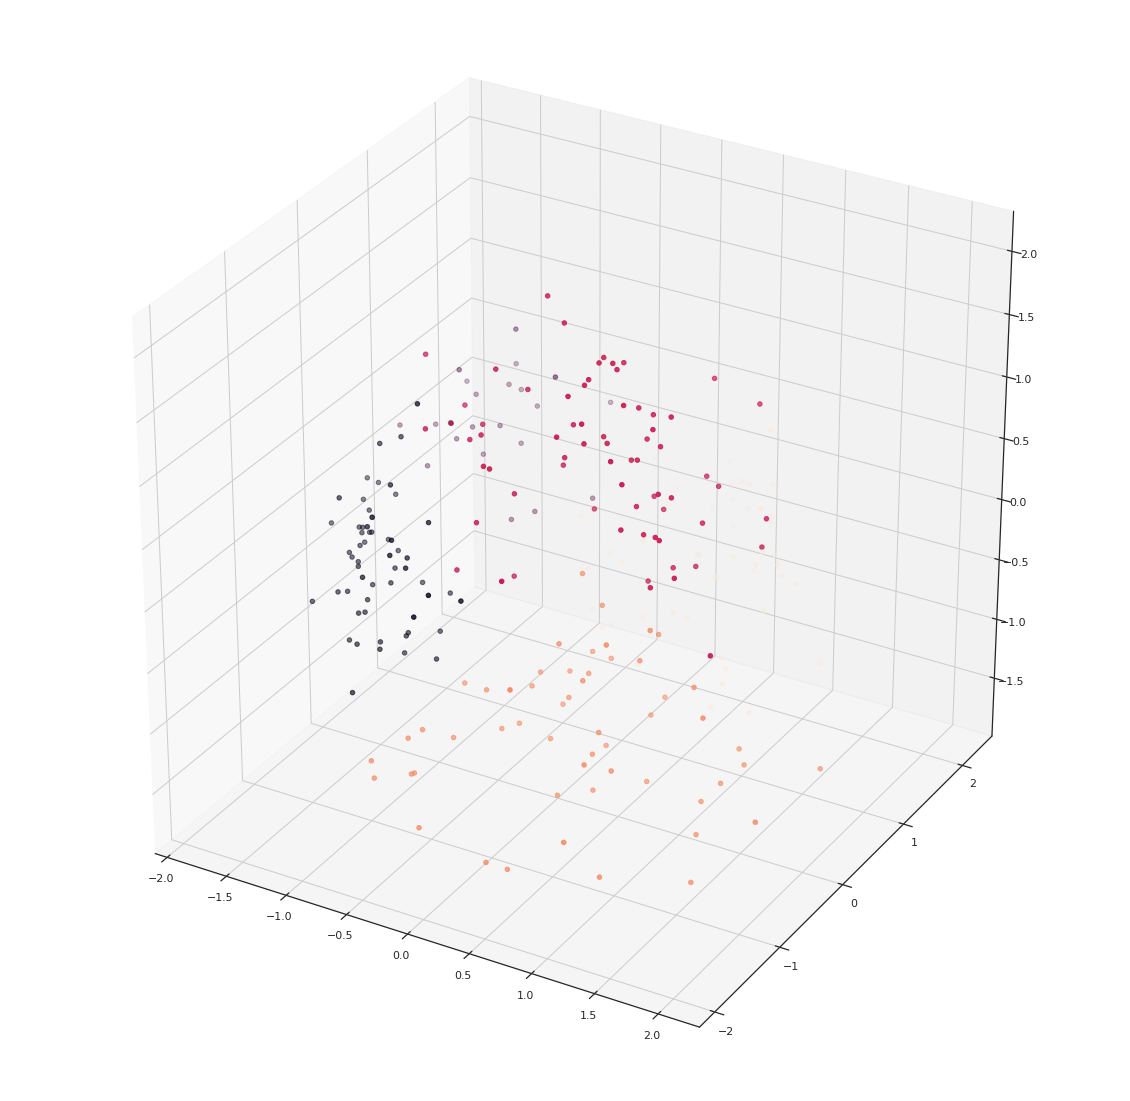

In [59]:
from sklearn.decomposition import FactorAnalysis
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
transformer = FactorAnalysis(n_components=3, random_state=0)
projected = transformer.fit_transform(X)
kmeans = KMeans(5).fit(projected)
intent_labels=kmeans.labels_
ax.scatter3D(projected[:,0], projected[:,1], projected[:,2], c=kmeans.labels_);

In [60]:
def calc_kmeans_errors(kmeans, X):
  errors = [0]*(kmeans.n_clusters)
  for r,l in zip(X, kmeans.labels_):
    errors[l] += np.linalg.norm(r-kmeans.cluster_centers_[l])
  return(sum(errors),sum(errors)/kmeans.n_clusters)
for nd in range(1,6):
  projected = FactorAnalysis(nd, random_state=0).fit_transform(X)
  for k in range(2,6):
    print(f'nd={nd}, k={k}')
    kmeans = KMeans(k).fit(projected)
    print(f'error = {[x//1 for x in calc_kmeans_errors(kmeans,projected)]}')

nd=1, k=2
error = [82.0, 41.0]
nd=1, k=3
error = [58.0, 19.0]
nd=1, k=4
error = [41.0, 10.0]
nd=1, k=5
error = [32.0, 6.0]
nd=2, k=2
error = [212.0, 106.0]
nd=2, k=3
error = [178.0, 59.0]
nd=2, k=4
error = [153.0, 38.0]
nd=2, k=5
error = [134.0, 26.0]
nd=3, k=2
error = [312.0, 156.0]
nd=3, k=3
error = [249.0, 83.0]
nd=3, k=4
error = [215.0, 53.0]
nd=3, k=5
error = [192.0, 38.0]
nd=4, k=2
error = [323.0, 161.0]
nd=4, k=3
error = [276.0, 92.0]
nd=4, k=4
error = [248.0, 62.0]
nd=4, k=5
error = [230.0, 46.0]
nd=5, k=2
error = [340.0, 170.0]
nd=5, k=3
error = [293.0, 97.0]
nd=5, k=4
error = [266.0, 66.0]
nd=5, k=5
error = [249.0, 49.0]


Text(0, 0.5, 'Eigenvalue')

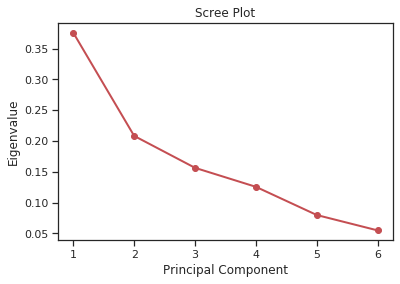

In [61]:
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')